## Setup

In [ ]:
# install dependencies
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# variables
KURTOSIS_WINDOW = "1300D"
DATA_FILE = 'crsp.csv'
FAMA_FRENCH_FACTORS = 'F-F_Research_Data_Factors.csv'

In [ ]:
# load data into memory
csrp = pd.read_csv(DATA_FILE)
csrp = csrp[['permno', 'comnam', 'date', 'ret', 'dlret']]

csrp['permno'] = pd.to_numeric(csrp['permno'], errors='coerce')
csrp['ret'] = pd.to_numeric(csrp['ret'], errors='coerce')
csrp['dlret'] = pd.to_numeric(csrp['dlret'], errors='coerce')
csrp['date'] = pd.to_datetime(csrp['date'], format='%Y%m%d')

In [ ]:
# load fama french factors into memory
ff_factors = pd.read_csv(FAMA_FRENCH_FACTORS)
ff_factors['date'] = pd.to_datetime(ff_factors['date'], format='%Y%m')

In [ ]:
# preprocess data
# if we have multiple entries for the same permno and date, take mean 
csrp = csrp.groupby(['permno', 'date']).agg({
    'ret': 'mean',      
    'dlret': 'mean',    
}).reset_index()

csrp['date'] = csrp['date'].dt.to_period('M')
ff_factors['date'] = ff_factors['date'].dt.to_period('M')

# sync factors and data
common_dates = pd.Series(list(set(csrp['date']).intersection(set(ff_factors['date']))))
csrp = csrp[csrp['date'].isin(common_dates)]
ff_factors = ff_factors[ff_factors['date'].isin(common_dates)]


## Experiment

In [ ]:
def calculate_kurtosis(df: pd.DataFrame):
    df['kurtosis'] = None

    for _, group in df.groupby('permno'):
        k = group.set_index('date').to_timestamp()['ret'].rolling(window=KURTOSIS_WINDOW).kurt()
        df.loc[group.index, 'kurtosis'] = k.values

    return df.dropna(subset=['kurtosis'])

In [ ]:
# calculate kurtosis
csrp = calculate_kurtosis(csrp)

In [ ]:
# assign quantiles based on kurtosis for each month
csrp['quantile'] = csrp.groupby('date')['kurtosis'].transform(
    lambda x: pd.qcut(x, q=10, labels=False)
)

### Motivation

In [ ]:
# calculate returns for each quantile (assuming long position and equal weights)
historical_quantile_returns_table = csrp.groupby(['date', 'quantile']).agg({'ret': 'mean', 'kurtosis':'mean'}).reset_index()

historical_quantile_returns = []
historical_quantile_kurtosis = []

for quantile in historical_quantile_returns_table['quantile'].unique():
    quantile_data = historical_quantile_returns_table[historical_quantile_returns_table['quantile'] == quantile]
    historical_quantile_kurtosis.append(quantile_data['kurtosis'].mean())
    historical_quantile_returns.append(quantile_data['ret'].mean())


plot_data = [[f"Q{i+1}", f"{historical_quantile_returns[i]:.4f}", f"{historical_quantile_kurtosis[i]:.4f}"] for i in range(10)]

fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=plot_data,
    colLabels=["Quantile", "Mean Return (All Time)", "Mean Kurtosis (All Time)"],
    loc="center",
    cellLoc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(plot_data[0]))))

plt.title("Quantile Statistics Table", fontsize=14)
plt.show()

Quantiles with higher kurtosis appear to perform better than those with low.

In [ ]:
# calculate autocorrelation of kurtosis
ac1 = csrp.groupby('permno')['kurtosis'].apply(lambda x: x.autocorr(lag=1)).mean()

print("Mean autocorrelation of kurtosis: ", ac1)

Autocorrelation of kurtosis appears to be high, indicating we could try using it as a signal for portfolio creation.

### Portfolio creation

In [ ]:
# shift csrp values by one month
csrp = csrp.sort_values(['permno', 'date'])

csrp['ret'] = csrp.groupby('permno')['ret'].transform(lambda x: x.shift(-1))
csrp['dlret'] = csrp.groupby('permno')['dlret'].transform(lambda x: x.shift(-1))

# adjust scale of ff factors
ff_factors['MKT_RF'] = ff_factors['MKT_RF'] / 100
ff_factors['SMB'] = ff_factors['SMB'] / 100
ff_factors['HML'] = ff_factors['HML'] / 100
ff_factors['RF'] = ff_factors['RF'] / 100

# remove the last month from csrp and ff_factors
last_month = csrp['date'].max()
csrp = csrp[csrp['date'] < last_month]

In [ ]:
# first dates should be alligned
print(csrp.sort_values('date').head())
print(ff_factors.sort_values('date').head())

# there should be no NaN in ff_factors, last date in data should be NaN and last date should allign
print(csrp.sort_values('date').tail())  
print(ff_factors.tail()) 

In [ ]:
def create_portfolio(df: pd.DataFrame, long, short = None):
    long_portfolio = df[df['quantile'].isin(long)].copy()
    long_portfolio.loc[:, 'position'] = 'long'  

    if short is not None:
        short_portfolio = df[df['quantile'].isin(short)].copy()
        short_portfolio.loc[:, 'position'] = 'short'  
        portfolio = pd.concat([long_portfolio, short_portfolio], axis=0)
    else:
        portfolio = long_portfolio

    return portfolio

def calculate_portfolio_returns(portfolio: pd.DataFrame):
    portfolio = portfolio.copy()

    # if ret is NaN and dlret is not NaN, set ret to 0 
    mask_delist = portfolio['dlret'].notna() & portfolio['ret'].isna()
    portfolio.loc[mask_delist, 'ret'] = 0

    # drop any rows where both ret and dlret are NaN 
    portfolio = portfolio.dropna(subset=['ret'])

    # fill dlret NaNs with 0
    portfolio['dlret'] = portfolio['dlret'].fillna(0)

    # calculate month's total return
    portfolio['total_return'] = (1 + portfolio['ret']) * (1 + portfolio['dlret']) - 1

    # calculate mean return for long and short positions
    long_return = portfolio[portfolio['position'] == 'long']['total_return'].mean()
    short_return = portfolio[portfolio['position'] == 'short']['total_return'].mean()

    if pd.isna(short_return):
        short_return = 0

    portfolio_return = long_return - short_return

    return portfolio_return



In [ ]:
portfolio_small_returns = []
portfolio_large_returns = []
quantile_returns = {q: [] for q in range(10)}

# Group data by month
grouped_months = csrp.groupby('date')

for month, month_data in grouped_months:
    next_month = month + 1

    # Create portfolios
    portfolio_small = create_portfolio(month_data, [9], [0])
    portfolio_large = create_portfolio(month_data, [9, 8], [0, 1])

    # Calculate portfolio returns
    portfolio_small_returns.append((next_month, calculate_portfolio_returns(portfolio_small)))
    portfolio_large_returns.append((next_month, calculate_portfolio_returns(portfolio_large)))

    # Calculate quantile returns
    for q in range(10):
        quantile_data = month_data[month_data['quantile'] == q]
        quantile_data = quantile_data.assign(position="long")
        quantile_returns[q].append((next_month, calculate_portfolio_returns(quantile_data)))

# Convert results to time series
port_small_series = pd.Series(dict(portfolio_small_returns)).sort_index()
port_large_series = pd.Series(dict(portfolio_large_returns)).sort_index()
quantile_series = {q: pd.Series(dict(returns)).sort_index() for q, returns in quantile_returns.items()}

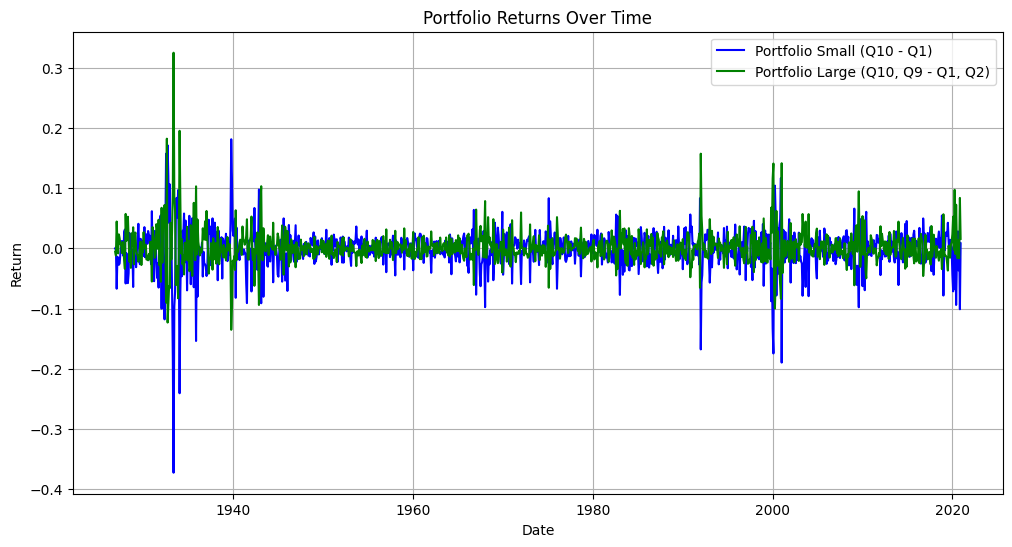

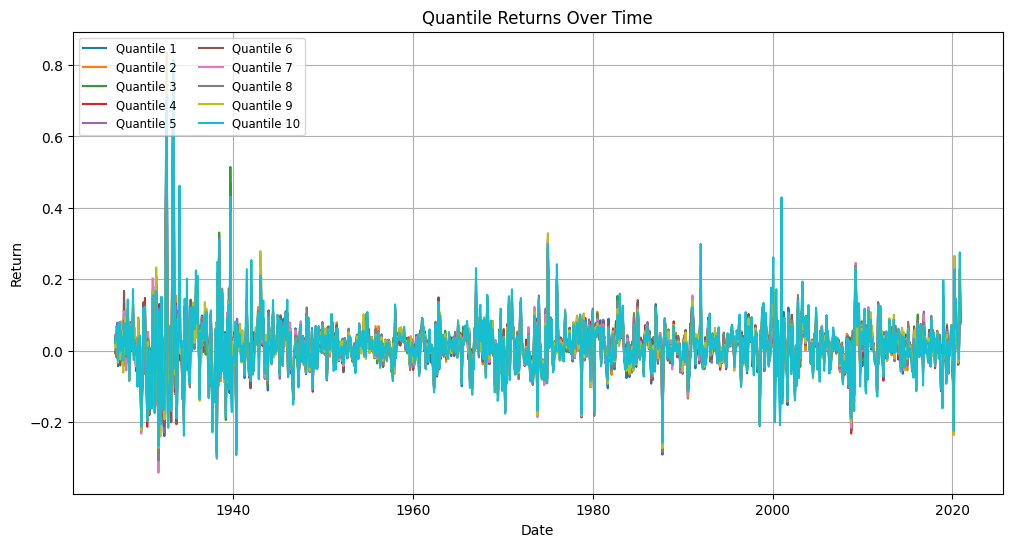

In [130]:
# Plot portfolio returns
plt.figure(figsize=(12, 6))
plt.plot(port_small_series.index.to_timestamp(), port_small_series.values, label="Portfolio Small (Q10 - Q1)", color="blue")
plt.plot(port_large_series.index.to_timestamp(), port_large_series.values, label="Portfolio Large (Q10, Q9 - Q1, Q2)", color="green")
plt.xlabel("Date")
plt.ylabel("Return")
plt.title("Portfolio Returns Over Time")
plt.legend()
plt.grid()
plt.show()

# Plot quantile returns_
plt.figure(figsize=(12, 6))
for q, series in quantile_series.items():
    plt.plot(series.index.to_timestamp(), series.values, label=f"Quantile {q+1}")
plt.xlabel("Date")
plt.ylabel("Return")
plt.title("Quantile Returns Over Time")
plt.legend(loc="upper left", fontsize="small", ncol=2)
plt.grid()
plt.show()

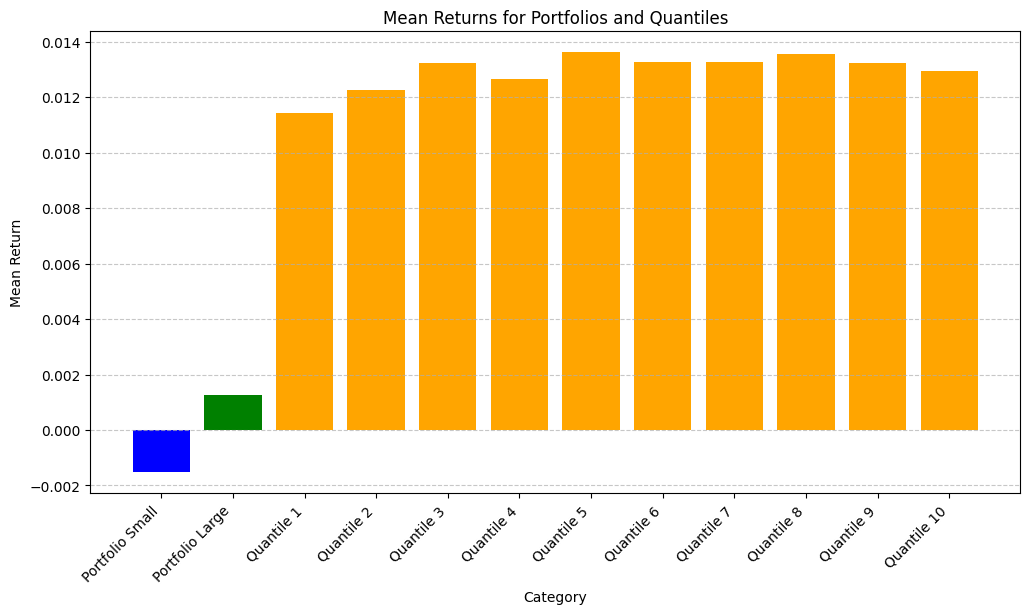

In [131]:
# plot mean return for each quantile and portfolio
mean_port_small = port_small_series.mean()
mean_port_large = port_large_series.mean()
mean_quantiles = {q: series.mean() for q, series in quantile_series.items()}

labels = ["Portfolio Small", "Portfolio Large"] + [f"Quantile {q+1}" for q in range(10)]
means = [mean_port_small, mean_port_large] + [mean_quantiles[q] for q in range(10)]

# Create bar chart
plt.figure(figsize=(12, 6))
plt.bar(labels, means, color=["blue", "green"] + ["orange"] * 10)
plt.xlabel("Category")
plt.ylabel("Mean Return")
plt.title("Mean Returns for Portfolios and Quantiles")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### Portfolio evaluation

In [132]:
def fama_french(data: pd.Series, factors: pd.DataFrame):
    data = data.reset_index()
    if data.shape[1] != 2:
        raise ValueError("Data series must have a datetime index and one return column.")
    data.columns = ['date', 'total_return']

    # Match date with factors
    regression_in = pd.merge(data, factors, on='date', how='inner')

    # Compute excess return
    regression_in['excess_return'] = regression_in['total_return'] - regression_in['RF']

    # Check for NaNs in critical columns
    critical_cols = ['total_return', 'MKT_RF', 'SMB', 'HML', 'RF', 'excess_return']
    if regression_in[critical_cols].isna().any().any():
        raise ValueError(f"NaN values found in critical columns: {regression_in[critical_cols].isna().sum()}")

    # Prepare regression data
    X = regression_in[['MKT_RF', 'SMB', 'HML']].apply(pd.to_numeric, errors='raise')
    X = sm.add_constant(X, has_constant='add')
    y = pd.to_numeric(regression_in['excess_return'], errors='raise')

    # Run regression
    model = sm.OLS(y, X).fit()
    return model


def capm(data: pd.Series, factors: pd.DataFrame):
    # Ensure correct structure
    data = data.reset_index()
    if data.shape[1] != 2:
        raise ValueError("Data series must have a datetime index and one return column.")
    data.columns = ['date', 'total_return']

    # Match date with factors
    regression_in = pd.merge(data, factors, on='date', how='inner')

    # Compute excess return
    regression_in['excess_return'] = regression_in['total_return'] - regression_in['RF']

    # Check for NaNs in critical columns
    critical_cols = ['total_return', 'MKT_RF', 'RF', 'excess_return']
    if regression_in[critical_cols].isna().any().any():
        raise ValueError(f"NaN values found in critical columns: {regression_in[critical_cols].isna().sum()}")

    # Prepare regression data
    X = pd.to_numeric(regression_in['MKT_RF'], errors='raise')
    X = sm.add_constant(X, has_constant='add')
    y = pd.to_numeric(regression_in['excess_return'], errors='raise')

    # Run regression
    model = sm.OLS(y, X).fit()
    return model


In [133]:
# find alphas for portfolios
portfolio_small_model = fama_french(port_small_series, ff_factors)
portfolio_large_model = fama_french(port_large_series, ff_factors)

portfolio_alphas = [portfolio_small_model.params['const'], portfolio_large_model.params['const']]
quantile_alphas = []

portfolio_tvalues = [
    portfolio_small_model.tvalues['const'],
    portfolio_large_model.tvalues['const']
]
quantile_tvalues = []

# find alphas for quantiles
for q in range(10):
    model = fama_french(quantile_series[q], ff_factors)
    quantile_alphas.append(model.params['const'])
    quantile_tvalues.append(model.tvalues['const'])


# find betas for portfolios
portfolio_small_beta_model = capm(port_small_series, ff_factors)
portfolio_large_beta_model = capm(port_large_series, ff_factors)

portfolio_betas = [portfolio_small_beta_model.params['MKT_RF'], portfolio_large_beta_model.params['MKT_RF']]
quantile_betas = []

portfolio_tvalues_beta = [
    portfolio_small_beta_model.tvalues['MKT_RF'],
    portfolio_large_beta_model.tvalues['MKT_RF']
]
quantile_tvalues_beta = []

# find betas for quantiles
for q in range(10):
    model = capm(quantile_series[q], ff_factors)
    quantile_betas.append(model.params['MKT_RF'])
    quantile_tvalues_beta.append(model.tvalues['MKT_RF'])

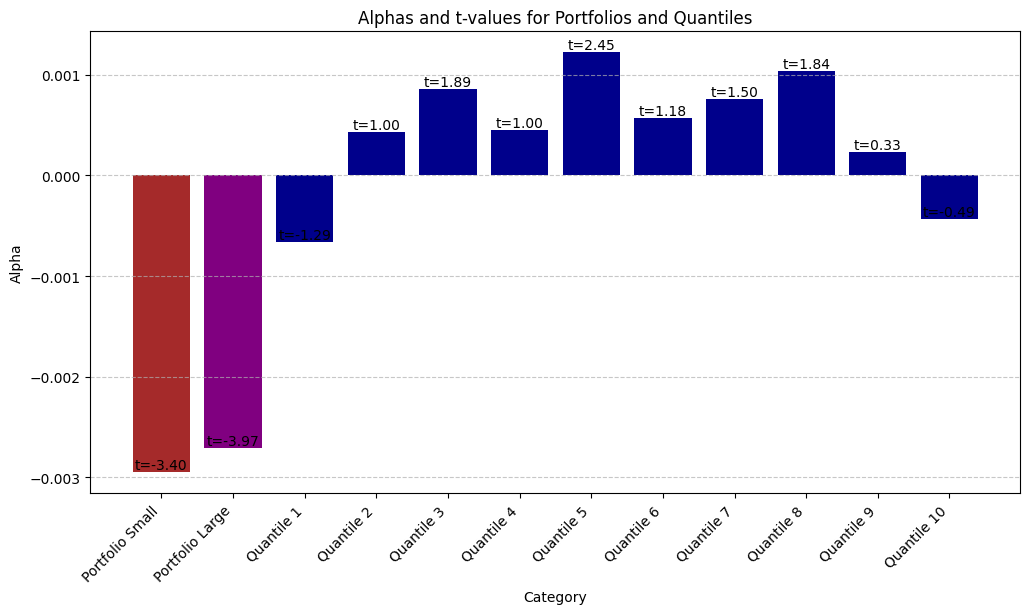

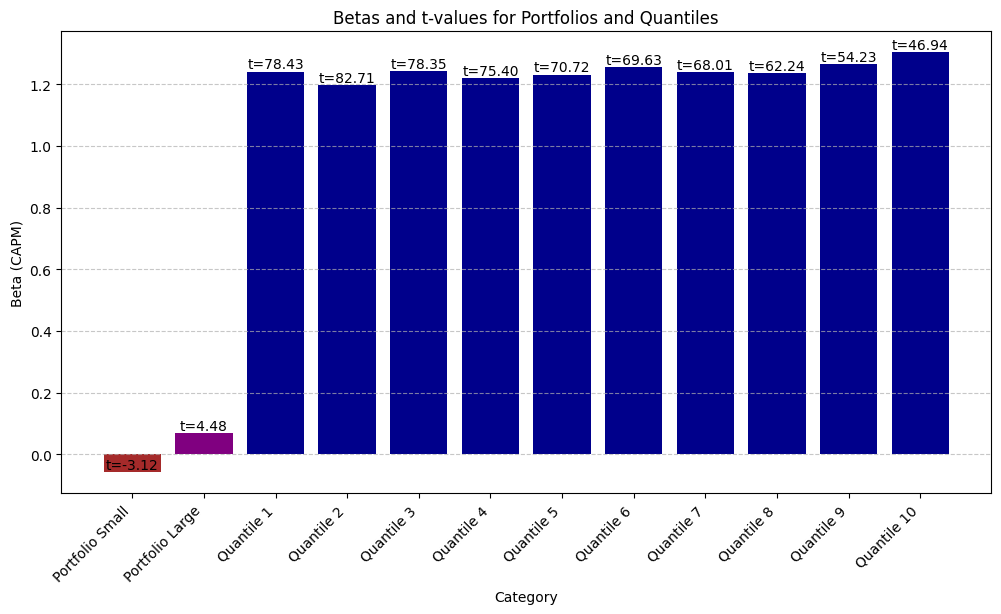

In [134]:
# plot alphas and betas
labels = ["Portfolio Small", "Portfolio Large"] + [f"Quantile {q+1}" for q in range(10)]
alphas = portfolio_alphas + quantile_alphas
tvalues = portfolio_tvalues + quantile_tvalues

plt.figure(figsize=(12, 6))
bars = plt.bar(labels, alphas, color=["brown", "purple"] + ["darkblue"] * 10)

for bar, alpha, tvalue in zip(bars, alphas, tvalues):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"t={tvalue:.2f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.xlabel("Category")
plt.ylabel("Alpha")
plt.title("Alphas and t-values for Portfolios and Quantiles")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# create charts for betas
labels = ["Portfolio Small", "Portfolio Large"] + [f"Quantile {q+1}" for q in range(10)]
betas = portfolio_betas + quantile_betas
tvalues_beta = portfolio_tvalues_beta + quantile_tvalues_beta

plt.figure(figsize=(12, 6))
bars = plt.bar(labels, betas, color=["brown", "purple"] + ["darkblue"] * 10)

for bar, beta, tvalue in zip(bars, betas, tvalues_beta):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"t={tvalue:.2f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.xlabel("Category")
plt.ylabel("Beta (CAPM)")
plt.title("Betas and t-values for Portfolios and Quantiles")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [135]:
# define sharpe ratio
def sharpe_ratio(data: pd.Series, factors):
    data = data.reset_index()  
    data.columns = ['date', 'total_return']  

    # match date with factors
    returns_in = pd.merge(data, factors, on='date', how='left')

    # Compute excess return
    returns_in['excess_return'] = returns_in['total_return'] - returns_in['RF']

    # return sharpe ratio
    return returns_in['excess_return'].mean() / returns_in['excess_return'].std() * np.sqrt(12)

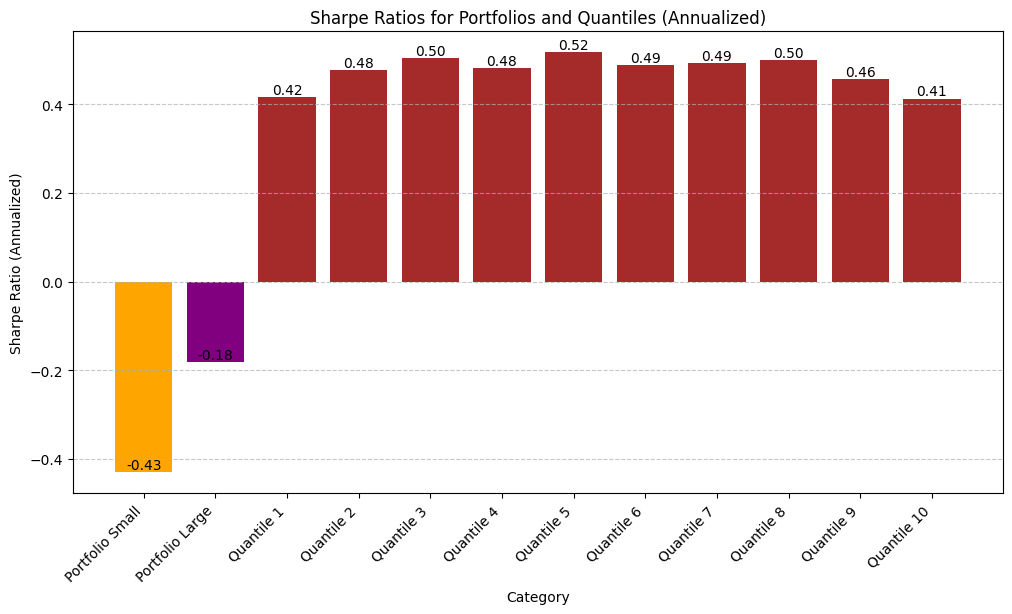

In [136]:
# calculate sharpe ratio for portfolios and quantiles
portfolio_small_sharpe = sharpe_ratio(port_small_series, ff_factors)
portfolio_large_sharpe = sharpe_ratio(port_large_series, ff_factors)
quantile_sharpe = [sharpe_ratio(quantile_series[q], ff_factors) for q in range(10)]

# create bar chart for sharpe ratio
labels = ["Portfolio Small", "Portfolio Large"] + [f"Quantile {q+1}" for q in range(10)]
sharpe_values = [portfolio_small_sharpe, portfolio_large_sharpe] + quantile_sharpe   
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, sharpe_values, color=["orange", "purple"] + ["brown"] * 10)
for bar, tvalue in zip(bars, sharpe_values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{tvalue:.2f}",
        ha="center",
        va="bottom",
        fontsize=10
    )
plt.xlabel("Category")
plt.ylabel("Sharpe Ratio (Annualized)")
plt.title("Sharpe Ratios for Portfolios and Quantiles (Annualized)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()